### Import Library

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Load Data

In [13]:
df = pd.read_csv('../data/raw/retail_price.csv')
df.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,...,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,39,161,2,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,39,161,2,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,39,161,2,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.95,39,161,2,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.95,39,161,2,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


### Feature Engineering (Competition)

In [14]:
for i in [1, 2, 3]:
  # Difference: (Our Price - Competitor's Price)
  # Positive = We are more expensive. Negative = We are cheaper (Discount)
  df[f'diff_comp_{i}'] = df['unit_price'] - df[f'comp_{i}']

  # Ratio (Our Price / Competitor's Price)
  # > 1 = More expensive. < 1 = Cheaper
  df[f'ratio_comp_{i}'] = df['unit_price'] / df[f'comp_{i}']

### Feature Engineering: TIME & SEASONALITY

In [15]:
# Parsing dates to capture monthly trends
df['date'] = pd.to_datetime(df['month_year'], format='%d-%m-%Y')
df['month'] = df['date'].dt.month

### Feature Engineering: ECONOMIC INDICATORS

In [16]:
df['total_cost'] = df['unit_price'] + df['freight_price']

### Data Cleaning & Encoding

In [17]:
# Drop the ID and Raw Date columns
cols_to_drop = ['product_id', 'month_year', 'date', 'total_price']
df_processed = df.drop(columns=cols_to_drop)

# One-Hot Encoding for Product Categories
df_processed = pd.get_dummies(df_processed, columns=['product_category_name'], drop_first=True)

# Fill in missing values (if there are no competitors, assume there is no difference)
df_processed = df_processed.fillna(0)

print(f"Shape Initial Data: {df.shape}")
print(f"Final Data Shape: {df_processed.shape}")
print("Feature Engineering Complete")


Shape Initial Data: (676, 38)
Final Data Shape: (676, 41)
Feature Engineering Complete


### Save Data

In [18]:
import os
os.makedirs('../data/processed', exist_ok=True)
df_processed.to_csv('../data/processed/train_data.csv', index=False)
print("Data saved to data/processed/train_data.csv")

Data saved to data/processed/train_data.csv


### Validation: Correlation Check

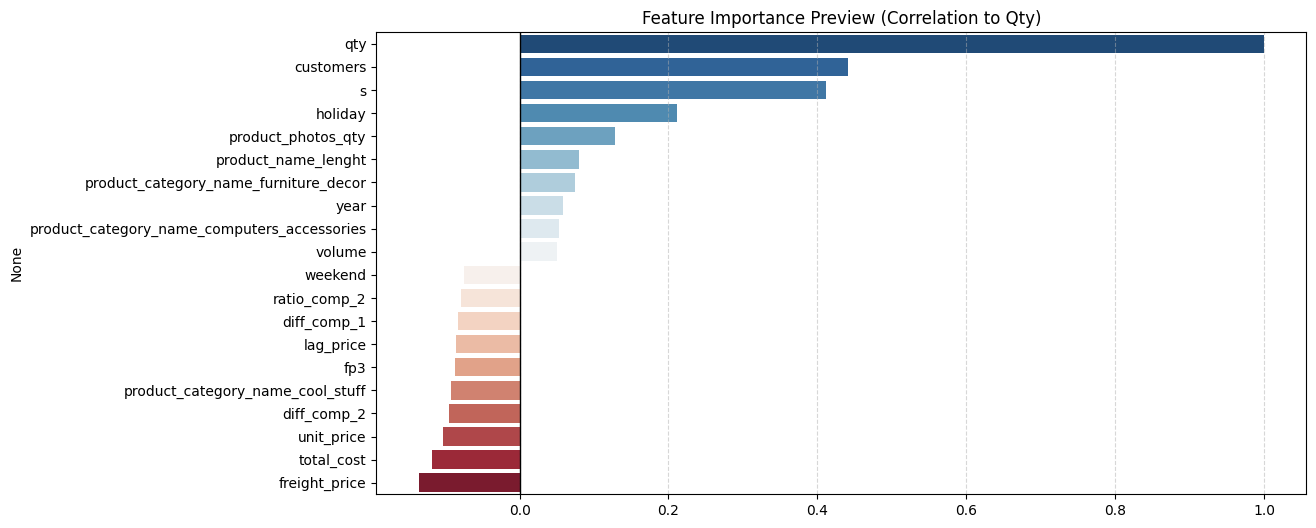

In [19]:
plt.figure(figsize=(12, 6))
corr_target = df_processed.corr()['qty'].sort_values(ascending=False)

top_features = pd.concat([corr_target.head(10), corr_target.tail(10)])

sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.index, palette='RdBu_r', legend=False)
plt.title('Feature Importance Preview (Correlation to Qty)')
plt.axvline(0, color='black', linewidth=1)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

## Feature Importance Analysis: Drivers of Demand

Based on the correlation chart, we validated the economic hypotheses embedded in our engineered features:

### 1. Validating the "Competitor Effect"
The engineered features (`diff_comp` and `ratio_comp`) exhibit a clear **Negative** correlation with `qty`.
* **Logic:** `diff_comp` represents (Our Price - Competitor Price).
* **Finding:** As this value increases (we become more expensive than competitors), sales volume (`qty`) decreases.
* **Significance:** This confirms that the model will be able to learn "Relative Pricing" strategies, not just absolute pricing.

### 2. Price Sensitivity (Law of Demand)
* **`unit_price` & `total_price`:** Show strong negative correlations. This aligns with fundamental economic theory: Price increase $\rightarrow$ Demand decrease.
* **`freight_price`:** Shipping costs also negatively impact conversion, acting as a friction point.

### 3. Quality vs. Price
* **`product_score`:** Shows a **Positive** correlation.
* **Insight:** Higher product ratings drive higher sales volume, potentially acting as a buffer against price sensitivity.